# EuroSAT Land Use Classification with PyTorch - CNN & Transfer Learning
#Dataset: https://www.kaggle.com/datasets/apollo2506/eurosat-dataset/data

## importing libraries

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from PIL import Image
import os
from pathlib import Path
# import cv2
from collections import Counter
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [22]:
# Set random seeds for reproducibility

In [46]:
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [47]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [48]:
# EuroSAT class names
CLASS_NAMES = [
    'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
    'Industrial', 'Pasture', 'PermanentCrop', 'Residential',
    'River', 'SeaLake'
]

In [49]:
# Configuration
IMG_SIZE = 224  # Using 224 for transfer learning compatibility
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001
NUM_WORKERS = 8  # Adjust based on your system

In [50]:
class EuroSATDataset(Dataset):
    """Custom Dataset class for EuroSAT"""

    def __init__(self, data_path, transform=None, class_names=None):
        self.data_path = Path(data_path)
        self.transform = transform
        self.class_names = class_names or CLASS_NAMES
        self.class_to_idx = {name: idx for idx, name in enumerate(self.class_names)}

        self.samples = []
        self._load_samples()

    def _load_samples(self):
        """Load all image paths and labels"""
        for class_name in self.class_names:
            class_path = self.data_path / class_name
            if not class_path.exists():
                print(f"Warning: Class folder {class_name} not found")
                continue

            # Get all image files
            image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
            image_files = []
            for ext in image_extensions:
                image_files.extend(list(class_path.glob(ext)))

            for img_path in image_files:
                self.samples.append((str(img_path), self.class_to_idx[class_name]))

            print(f"Found {len(image_files)} images for class {class_name}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        # Load image
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [51]:
def get_transforms(img_size=224):
    """Get data transforms for training and validation"""

    # Training transforms with augmentation
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Validation transforms (no augmentation)
    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform

In [52]:
def create_data_loaders(data_path, batch_size=32, val_split=0.2, test_split=0.2, img_size=224):
    """Create PyTorch data loaders"""

    train_transform, val_transform = get_transforms(img_size)

    # Create full dataset
    full_dataset = EuroSATDataset(data_path, transform=val_transform)

    # Calculate split sizes
    total_size = len(full_dataset)
    test_size = int(test_split * total_size)
    val_size = int(val_split * (total_size - test_size))
    train_size = total_size - val_size - test_size

    print(f"Dataset splits: Train={train_size}, Val={val_size}, Test={test_size}")

    # Split dataset
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Apply transforms to training set
    train_dataset.dataset.transform = train_transform

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=NUM_WORKERS, pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=True
    )

    return train_loader, val_loader, test_loader

In [53]:
class CustomCNN(nn.Module):
    """Custom CNN architecture for EuroSAT classification"""

    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()

        # Feature extraction layers
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),
        )

        # Adaptive pooling to handle different input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def create_transfer_learning_model(model_name, num_classes=10, pretrained=True):
    """Create transfer learning models"""
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=pretrained)
        for param in model.parameters():  # Freeze all layers
            param.requires_grad = False
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        for param in model.fc.parameters():  # Unfreeze classifier
            param.requires_grad = True

    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=pretrained)
        num_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    elif model_name == 'vit_b_16':  # Vision Transformer
        model = models.vit_b_16(pretrained=pretrained)
        num_features = model.heads.head.in_features
        model.heads.head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    else:
        raise ValueError(f"Unsupported model: {model_name}")

    return model

In [54]:
from torch.cuda.amp import GradScaler, autocast

def train_model(model, train_loader, val_loader, num_epochs, device, model_name):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    scaler = GradScaler()  # Initialize scaler for mixed precision

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_acc = 0.0
    patience_counter = 0
    patience = 10

    print(f"\nTraining {model_name}...")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch_idx, (data, target) in enumerate(train_pbar):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            with autocast():  # Enable mixed precision
                output = model(data)
                loss = criterion(output, target)

            scaler.scale(loss).backward()  # Scale gradients
            scaler.step(optimizer)         # Update weights
            scaler.update()                # Update scaler

            train_loss += loss.item()
            _, predicted = output.max(1)
            train_total += target.size(0)
            train_correct += predicted.eq(target).sum().item()

            train_pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{100.*train_correct/train_total:.2f}%'})

        # Validation phase (unchanged, but can also use autocast)
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for data, target in val_pbar:
                data, target = data.to(device), target.to(device)
                with autocast():
                    output = model(data)
                    loss = criterion(output, target)
                val_loss += loss.item()
                _, predicted = output.max(1)
                val_total += target.size(0)
                val_correct += predicted.eq(target).sum().item()
                val_pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{100.*val_correct/val_total:.2f}%'})

        # Calculate epoch metrics and update history
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f'best_{model_name.lower()}_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

    model.load_state_dict(torch.load(f'best_{model_name.lower()}_model.pth'))
    return model, history

In [55]:
def evaluate_model(model, test_loader, device, class_names, model_name):
    """Evaluate model performance"""

    model = model.to(device)
    model.eval()

    all_preds = []
    all_targets = []
    all_probs = []

    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc=f'Evaluating {model_name}')
        for data, target in test_pbar:
            data, target = data.to(device), target.to(device)
            output = model(data)
            probs = F.softmax(output, dim=1)
            _, predicted = output.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_preds)
    precision, recall, f1, support = precision_recall_fscore_support(
        all_targets, all_preds, average=None, zero_division=0
    )

    # Create results dataframe
    results_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })

    # Overall metrics
    macro_avg = precision_recall_fscore_support(all_targets, all_preds, average='macro', zero_division=0)
    weighted_avg = precision_recall_fscore_support(all_targets, all_preds, average='weighted', zero_division=0)

    print(f"\n{model_name} Results:")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Macro Average - Precision: {macro_avg[0]:.4f}, Recall: {macro_avg[1]:.4f}, F1: {macro_avg[2]:.4f}")
    print(f"Weighted Average - Precision: {weighted_avg[0]:.4f}, Recall: {weighted_avg[1]:.4f}, F1: {weighted_avg[2]:.4f}")
    print("\nPer-class metrics:")
    print(results_df.round(4))

    return results_df, accuracy, all_preds, all_targets

In [56]:
def plot_training_history(history, model_name):
    """Plot training history"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss plot
    ax1.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    ax1.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    ax1.set_title(f'{model_name} - Training & Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    ax2.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    ax2.set_title(f'{model_name} - Training & Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    """Plot confusion matrix"""

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [57]:
def compare_models(results_dict):
    """Compare model performances"""

    comparison_df = pd.DataFrame({
        model_name: {
            'Accuracy': results['accuracy'],
            'Macro Avg F1': results['results_df']['F1-Score'].mean(),
            'Weighted Avg F1': np.average(
                results['results_df']['F1-Score'],
                weights=results['results_df']['Support']
            )
        }
        for model_name, results in results_dict.items()
    }).T

    print("\n" + "="*50)
    print("MODEL COMPARISON")
    print("="*50)
    print(comparison_df.round(4))

    # Plot comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    metrics = ['Accuracy', 'Macro Avg F1', 'Weighted Avg F1']
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum']

    for i, metric in enumerate(metrics):
        comparison_df[metric].plot(kind='bar', ax=axes[i], color=colors[:len(comparison_df)])
        axes[i].set_title(f'{metric} Comparison')
        axes[i].set_ylabel(metric)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylim([0, 1])

    plt.tight_layout()
    plt.show()

    return comparison_df

In [58]:
def visualize_sample_predictions(model, test_loader, device, class_names, model_name, num_samples=8):
    """Visualize sample predictions"""

    model.eval()
    model = model.to(device)

    # Get a batch of test data
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    # Select random samples
    indices = np.random.choice(len(images), num_samples, replace=False)

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        _, predictions = torch.max(outputs, 1)

    for i, idx in enumerate(indices):
        # Denormalize image for display
        img = images[idx].cpu()
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0)

        axes[i].imshow(img)

        true_label = class_names[labels[idx]]
        pred_label = class_names[predictions[idx]]
        confidence = probabilities[idx][predictions[idx]].item() * 100

        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)',
                         color=color, fontsize=10)
        axes[i].axis('off')

    plt.suptitle(f'{model_name} - Sample Predictions', fontsize=16)
    plt.tight_layout()
    plt.show()

In [36]:
################################################################

In [59]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("apollo2506/eurosat-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/eurosat-dataset


In [60]:
# Update data_path if necessary (check dataset structure)
data_path = f"{path}/EuroSAT"  # Adjust based on actual folder structure

In [61]:
# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    data_path=data_path,
    batch_size=BATCH_SIZE,
    val_split=0.2,
    test_split=0.2,
    img_size=IMG_SIZE
)

Found 3000 images for class AnnualCrop
Found 3000 images for class Forest
Found 3000 images for class HerbaceousVegetation
Found 2500 images for class Highway
Found 2500 images for class Industrial
Found 2000 images for class Pasture
Found 2500 images for class PermanentCrop
Found 3000 images for class Residential
Found 2500 images for class River
Found 3000 images for class SeaLake
Dataset splits: Train=17280, Val=4320, Test=5400


In [40]:
# Dictionary to store results
results_dict = {}

# List of models to train
models_to_train = [
    ('EfficientNet_B0', create_transfer_learning_model('efficientnet_b0', num_classes=len(CLASS_NAMES), pretrained=True))
]

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 139MB/s]



=== Training and Evaluating EfficientNet_B0 ===

Training EfficientNet_B0...
Model parameters: 4,668,550


Epoch 1/10 [Val]: 100%|██████████| 68/68 [00:14<00:00,  4.79it/s, Loss=0.1710, Acc=92.29%]


Epoch 1: Train Loss: 0.2262, Train Acc: 0.9275, Val Loss: 0.2355, Val Acc: 0.9229


Epoch 2/10 [Val]: 100%|██████████| 68/68 [00:14<00:00,  4.57it/s, Loss=0.1961, Acc=96.41%]


Epoch 2: Train Loss: 0.1850, Train Acc: 0.9422, Val Loss: 0.1093, Val Acc: 0.9641


Epoch 3/10 [Val]: 100%|██████████| 68/68 [00:15<00:00,  4.44it/s, Loss=0.4055, Acc=93.77%]


Epoch 3: Train Loss: 0.1683, Train Acc: 0.9467, Val Loss: 0.1940, Val Acc: 0.9377


Epoch 4/10 [Val]: 100%|██████████| 68/68 [00:14<00:00,  4.70it/s, Loss=0.2058, Acc=94.54%]


Epoch 4: Train Loss: 0.1609, Train Acc: 0.9473, Val Loss: 0.1465, Val Acc: 0.9454


Epoch 5/10 [Val]: 100%|██████████| 68/68 [00:13<00:00,  4.86it/s, Loss=0.1856, Acc=94.51%]


Epoch 5: Train Loss: 0.1497, Train Acc: 0.9516, Val Loss: 0.1611, Val Acc: 0.9451


Epoch 6/10 [Val]: 100%|██████████| 68/68 [00:13<00:00,  4.92it/s, Loss=0.2322, Acc=95.58%]


Epoch 6: Train Loss: 0.1430, Train Acc: 0.9524, Val Loss: 0.1334, Val Acc: 0.9558


Epoch 7/10 [Val]: 100%|██████████| 68/68 [00:13<00:00,  4.86it/s, Loss=0.3985, Acc=94.77%]


Epoch 7: Train Loss: 0.1353, Train Acc: 0.9562, Val Loss: 0.1537, Val Acc: 0.9477


Epoch 8/10 [Val]: 100%|██████████| 68/68 [00:14<00:00,  4.82it/s, Loss=0.0419, Acc=94.88%]


Epoch 8: Train Loss: 0.1405, Train Acc: 0.9545, Val Loss: 0.1622, Val Acc: 0.9488


Epoch 9/10 [Val]: 100%|██████████| 68/68 [00:13<00:00,  4.88it/s, Loss=0.1617, Acc=97.20%]


Epoch 9: Train Loss: 0.0949, Train Acc: 0.9686, Val Loss: 0.0806, Val Acc: 0.9720


Epoch 10/10 [Val]: 100%|██████████| 68/68 [00:13<00:00,  4.87it/s, Loss=0.1890, Acc=97.43%]


Epoch 10: Train Loss: 0.0771, Train Acc: 0.9748, Val Loss: 0.0755, Val Acc: 0.9743


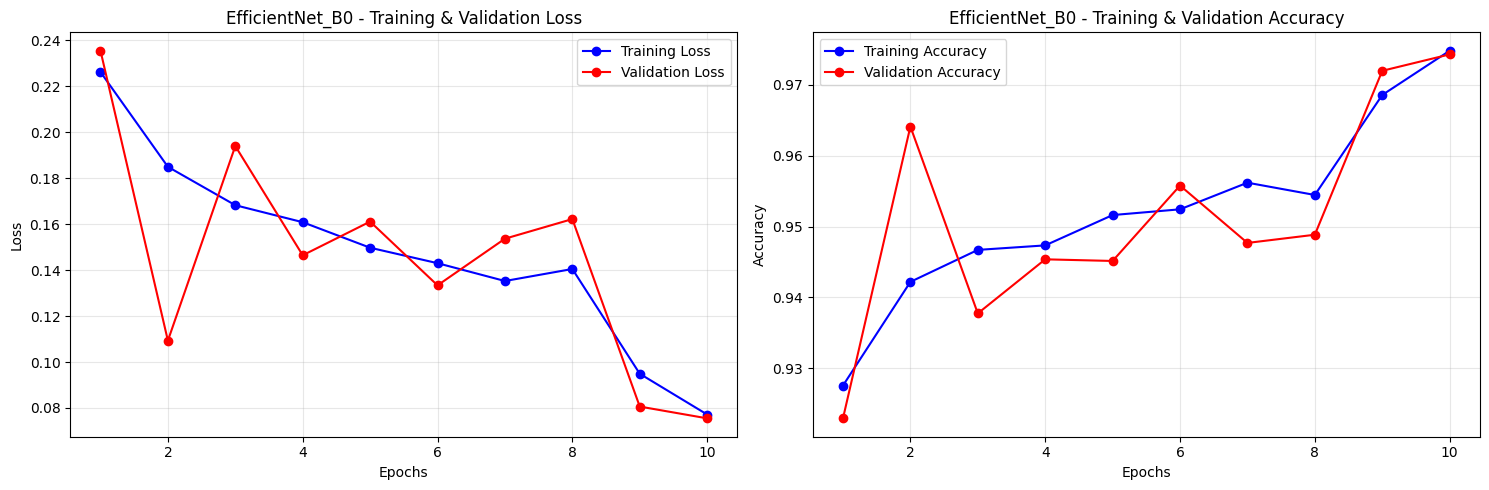

Evaluating EfficientNet_B0: 100%|██████████| 85/85 [00:18<00:00,  4.63it/s]



EfficientNet_B0 Results:
Overall Accuracy: 0.9719
Macro Average - Precision: 0.9722, Recall: 0.9703, F1: 0.9711
Weighted Average - Precision: 0.9722, Recall: 0.9719, F1: 0.9719

Per-class metrics:
                  Class  Precision  Recall  F1-Score  Support
0            AnnualCrop     0.9698  0.9683    0.9691      631
1                Forest     0.9965  0.9777    0.9870      582
2  HerbaceousVegetation     0.9338  0.9673    0.9502      612
3               Highway     0.9961  0.9619    0.9787      525
4            Industrial     0.9757  0.9938    0.9846      484
5               Pasture     0.9655  0.9192    0.9418      396
6         PermanentCrop     0.9507  0.9526    0.9516      506
7           Residential     0.9950  0.9901    0.9926      606
8                 River     0.9817  0.9718    0.9767      497
9               SeaLake     0.9573  1.0000    0.9782      561


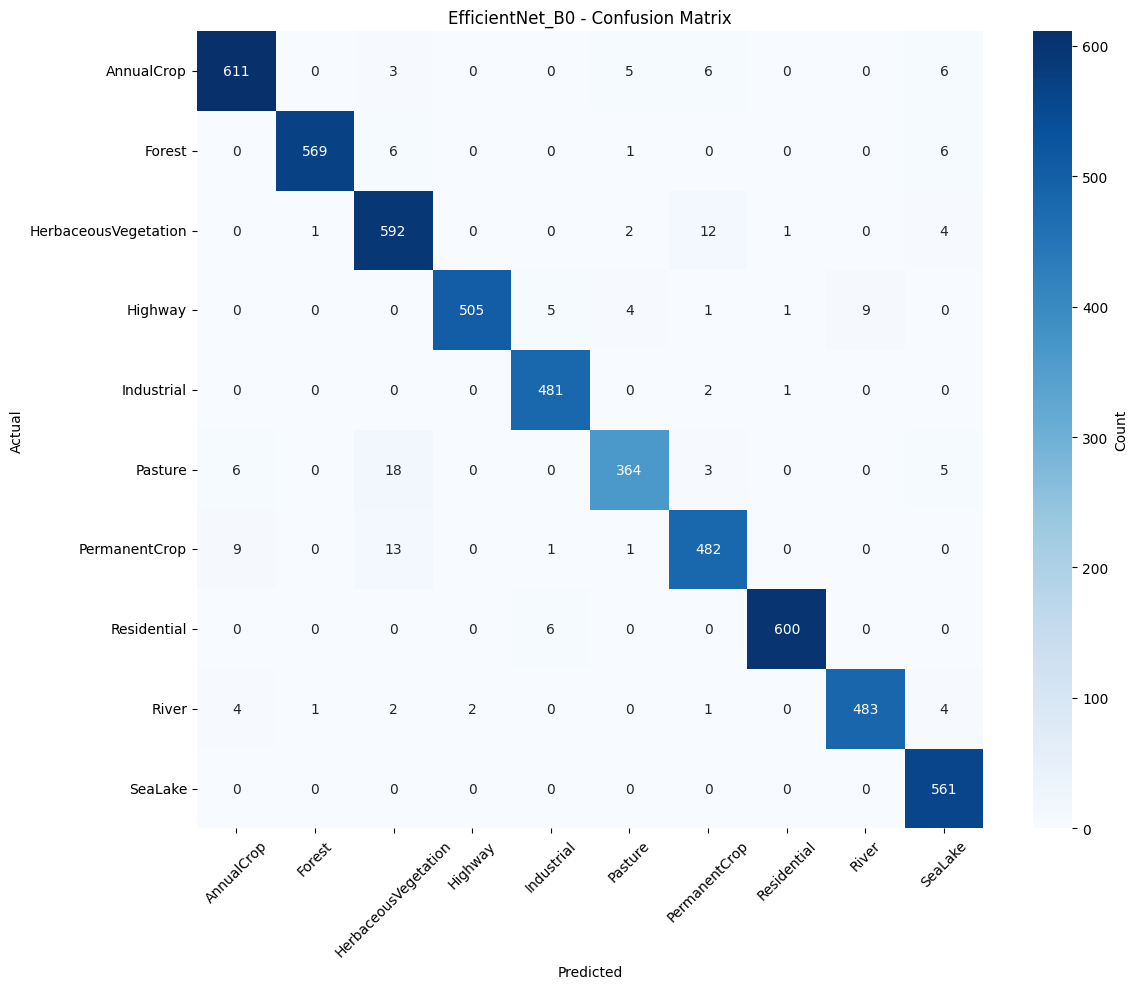

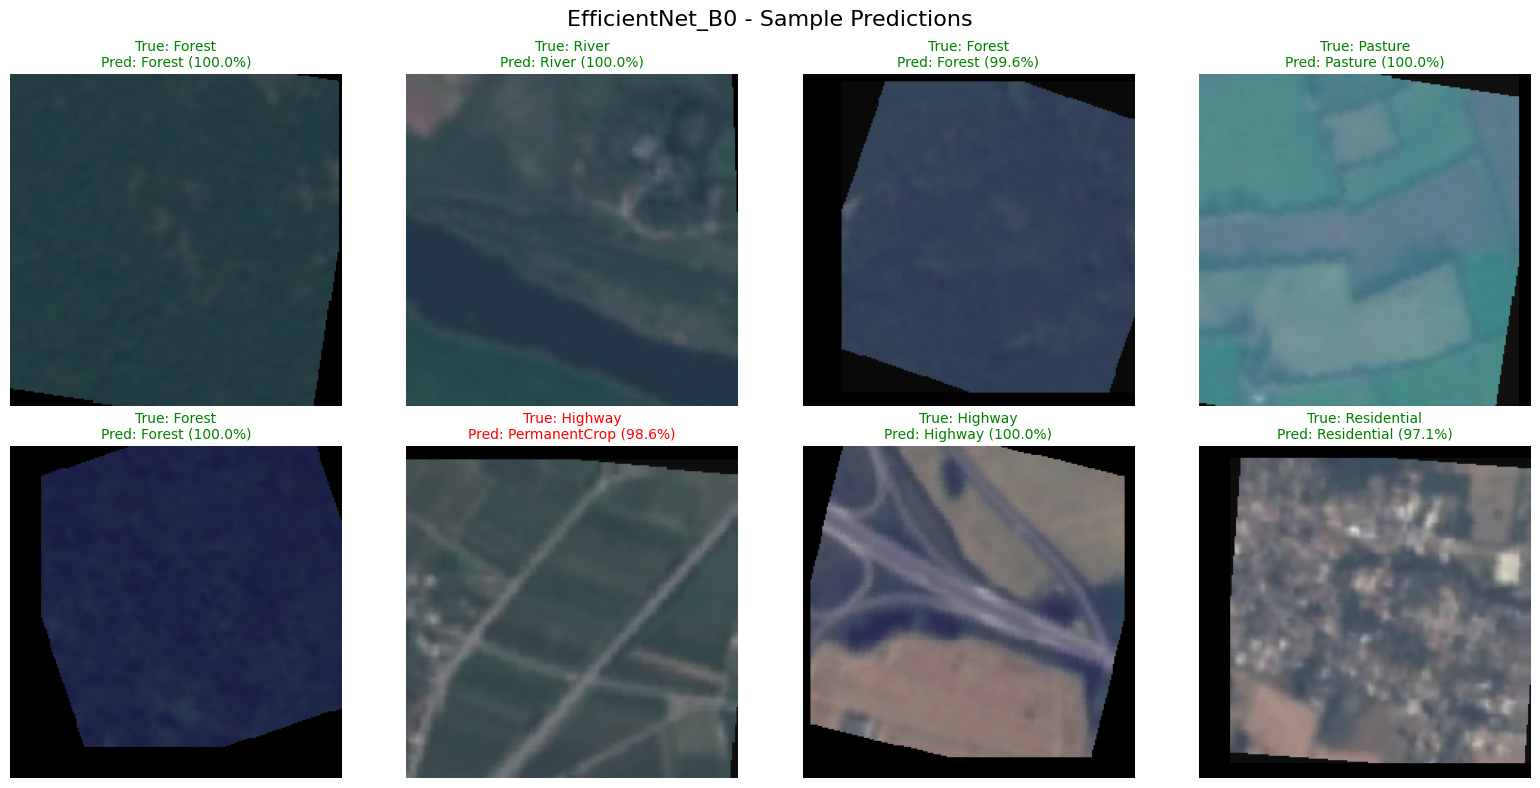

In [62]:
for model_name, model in models_to_train:
    print(f"\n=== Training and Evaluating {model_name} ===")

    # Train the model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=EPOCHS,
        device=device,
        model_name=model_name
    )

    # Plot training history
    plot_training_history(history, model_name)

    # Evaluate the model
    results_df, accuracy, all_preds, all_targets = evaluate_model(
        model=trained_model,
        test_loader=test_loader,
        device=device,
        class_names=CLASS_NAMES,
        model_name=model_name
    )

    # Store results
    results_dict[model_name] = {
        'results_df': results_df,
        'accuracy': accuracy,
        'all_preds': all_preds,
        'all_targets': all_targets
    }

    # Plot confusion matrix
    plot_confusion_matrix(all_targets, all_preds, CLASS_NAMES, model_name)

    # Visualize sample predictions
    visualize_sample_predictions(trained_model, test_loader, device, CLASS_NAMES, model_name)

In [63]:
torch.save(model.state_dict(), f'best_{model_name.lower()}_model.pth')